# Timestamp gaps investigation

As identified during on-site tests on 2023-07-12 (see [acada_lst1_int#85](https://gitlab.cta-observatory.org/cta-computing/common/acada-array-elements/acada_lst1_int/-/issues/85), [acada#1152](https://gitlab.cta-observatory.org/cta-computing/acada/array-control-and-data-acquisition/-/issues/1152), [mon#69](https://gitlab.cta-observatory.org/cta-computing/acada/mon/-/issues/69)), sporadic, large timestamp gaps are seen while a 1-Hz sampling rate is expected.

The purpose of this notebook is to perform the offline analysis of the collected data.

## Data collected

The data contained in the `*.csv` files are dumped from the Cassandra Database and have been collected during the MON&AAS acquisition.

The data contained in `*.txt` instead, have been taken as the stdout of the [`mon_events_consumer.py`](https://gitlab.cta-observatory.org/cta-computing/acada/mon-aas-deployment/-/blob/master/PythonKafkaConsumers/mon_events_consumer.py), which has been turned on for a few minutes only.

All the timestamps are UTC.

## N.B. Things to pay attention to:

Differences WRT OPC-UA investigation:

* We don't have the simulator output to compare our data with; 
* N.B. the `source_timestamp` variable has no digits after the comma, i.e., is an integer;

In [1]:
%%js
let cm = document.querySelector(".CodeMirror");
if (cm) delete cm.CodeMirror.constructor.keyMap.emacsy["Ctrl-a"];
if (cm) delete cm.CodeMirror.constructor.keyMap.emacsy["Ctrl-V"];   // delete CodeMirror's key binding of ctrl-v, so it falls back to the default action of ctrl-v which is "paste" in my system
if (cm) cm.CodeMirror.constructor.keyMap.emacsy["Ctrl-A"] = "selectAll";   // let ctrl-a be selectAll
if (cm) cm.CodeMirror.constructor.keyMap.emacsy["Ctrl-Z"] = "undo";

<IPython.core.display.Javascript object>

In [2]:
!ls

ACS.ipynb                          monitoring_point_2024_02_12m.csv
datapoint_metadata_2024_02_12m.csv new_ACS.ipynb
monCollector_2024_02_12.txt


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
sys.path.append("../")

from tqdm import tqdm
from datetime import datetime, timedelta
from tools_for_analysis import *

In [4]:
number_of_monitored_properties = 863 # Manually insert the theoretical number of monitored properties

df_kafka_unrestricted = parse_kafka_text_file("monCollector_2024_02_12.txt")
df_cassandra_unrestricted = read_cassandra_csv("monitoring_point_2024_02_12m.csv")

dataframe_names = ["Kafka", "Cassandra"]

2733283it [02:27, 18574.07it/s]
100%|██████████| 1366641/1366641 [00:01<00:00, 1095499.25it/s]


In [5]:
unrestricted_dataframes = [
    df_kafka_unrestricted, 
    df_cassandra_unrestricted
]

unrestricted_dataframes_dict = dict(
    zip(
        [dfn + " unrestricted" for dfn in dataframe_names], 
        unrestricted_dataframes
    )
)

In [6]:
# Check first and last timestamp for the entire dataframes
stamp_first_and_last_timestamp(unrestricted_dataframes_dict)

Kafka unrestricted dataframe timerange
2024-02-10 12:02:43
2024-02-12 11:36:27

Cassandra unrestricted dataframe timerange
2024-02-07 12:48:26
2024-02-12 11:32:24



In [7]:
# Restrict the time range to the one in which we are sure the monitoring is active
start_time = "2024-02-12 11:07:44.000" # Use UTC
end_time = "2024-02-12 11:36:26.000" # Use UTC
acquisition_duration_sec = get_interval_duration(start_time, end_time)

df_kafka_restricted = get_restricted_dataframe(
    df_kafka_unrestricted, 
    start_time, 
    end_time, 
    column="source_dt"
)
df_cassandra_restricted = get_restricted_dataframe(
    df_cassandra_unrestricted, 
    start_time, 
    end_time, 
    column="source_dt"
)

restricted_dataframes = [
    df_kafka_restricted, 
    df_cassandra_restricted
]

restricted_dataframes_dict = dict(zip(dataframe_names, restricted_dataframes))

# Check number of rows for the restricted dataframes
stamp_expected_number_of_rows(number_of_monitored_properties, acquisition_duration_sec)
stamp_number_of_rows_in_dataframe(restricted_dataframes_dict)

# Check first and last timestamp for the restricted dataframes
stamp_first_and_last_timestamp(restricted_dataframes_dict)

The acquisition interval duration in second is: 1722.0 (about 29 min)

The theoretical number of entries in dataframes for selected timerange is: 
             1486086

Number of rows in the selected timerange for dataframes:
     Kafka:  1206847
 Cassandra:  127250

Kafka dataframe timerange
2024-02-12 11:07:45
2024-02-12 11:36:25

Cassandra dataframe timerange
2024-02-12 11:07:45
2024-02-12 11:32:24



../tools_for_analysis.py:328: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe["assembly_name"] = (


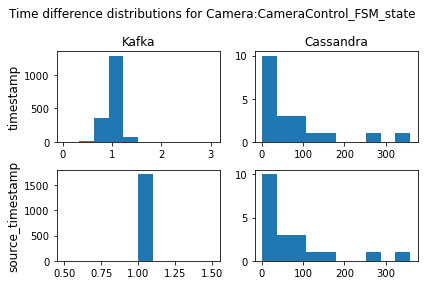

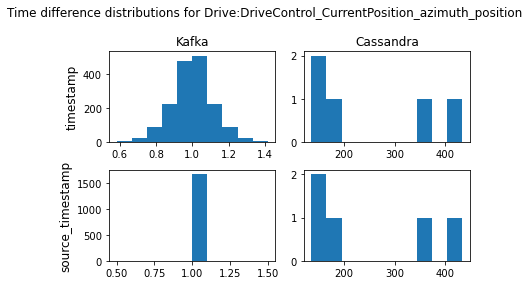

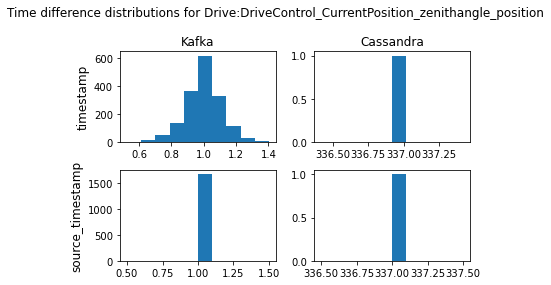

In [8]:
# Plot histograms of time differences for some assemblies and properties
assembly_names = [
    "Camera",
    "Drive",
    "Drive"
]

property_names = [
    "CameraControl_FSM_state",
    "DriveControl_CurrentPosition_azimuth_position",
    "DriveControl_CurrentPosition_zenithangle_position"
]

for a, n in zip(assembly_names, property_names):
    plot_time_differences(restricted_dataframes_dict, a, n)

Number of unique couples of assembly and property in dataframes:
     Kafka:  711
 Cassandra:  430

The following plot represents the distribution of the mean_values and standard_deviations of the 
source_timestamp differences for each unique couple of assembly and property.

N.B. If all the properties were sampled at 1 Hz, 
the expected distribution of the mean_values for 
all the monitored properties should be a Gaussian 
centered at 1 sec with a standard_deviation of milliseconds.



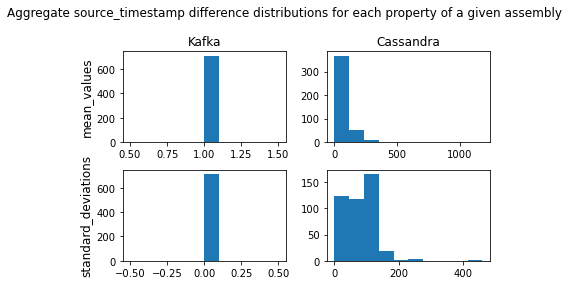

In [9]:
plot_aggregate_distributions(restricted_dataframes_dict)

The following plot represents the distribution of the acquisition duration for 
each unique couple assembly and property.

N.B. in the ideal case there should be only one bin centered at 1722.0


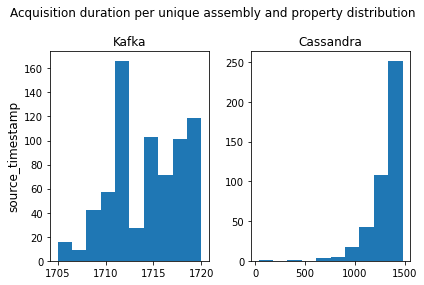

In [10]:
plot_acquisition_duration_per_property(restricted_dataframes_dict, acquisition_duration_sec)

The following plot represents the histogram of the source_timestamp. 
Each bin corresponds to the number of properties collected in the bin timerange.


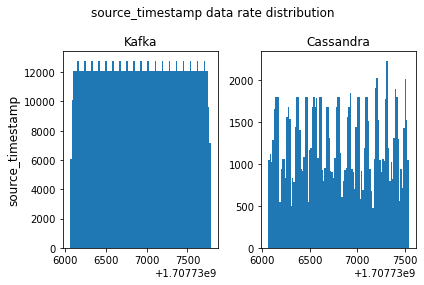

In [11]:
plot_data_rate_histogram(restricted_dataframes_dict)